# Collecting/Processing various gridded datasets to use in CO2 flux models


TODO
* soil grid: `/g/data/fj4/Soil_Landscape_grid/TERNLandscape_90m`
* Take 5 years of MODIS LULC and take MODE
* months since burn date: `/g/data/ub8/au/MODIS/mosaic/MCD64A1.006`
* Trends in climate variables like Tavg and VPD
* The time during which surface soil moisture is below seasonal average 
* MSWEP rainfall or CHIRPS rainfall instead of AWRA
* Soil grids: upper horizon organic carbon, clay, sand
* Fix LST-Tair

In [ ]:
import os
import odc.geo.xr
import xarray as xr
import numpy as np
import pandas as pd
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_gridded_data import collect_gridded_data

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

## Resampling GRAFS and LAI to monthly

In [ ]:
i=0
for y in range(2018, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2018, 2022))), end="")
    
    year = str(y)
    
    sws = xr.open_dataset('/g/data/fj4/SatelliteSoilMoistureProducts/S-GRAFS/ANNUAL_NC/surface_soil_moisture_vol_1km_'+year+'.nc',
                      chunks=dict(lat=1000, lon=1000))
    sws = assign_crs(sws, crs=sws.attrs['crs'][-9:])
    sws = sws.soil_moisture.where(sws >=0)
    sws = sws.soil_moisture.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute()
    sws = sws.rename({'lat':'latitude', 'lon':'longitude'})
    sws.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/GRAFS/GRAFS_1km_monthly_'+year+'.nc')
    i+=1
    
i=0
for y in range(2016, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2016, 2022))), end="")
    
    year = str(y)
    
    base = '/g/data/ub8/au/MODIS/mosaic/MOD15A2H.006/'
    lai = xr.open_dataset('/g/data/ub8/au/MODIS/mosaic/MOD15A2H.006/MOD15A2H.006.b02.500m_lai.'+year+'.nc',
                          chunks=dict(latitude=1000, longitude=1000))
    lai = assign_crs(lai, crs='epsg:4326')
    lai = lai['500m_lai'].rename('lai') #tidy up the dataset
    lai = lai.where((lai <= 10) & (lai >=0)) #remove artefacts and 'no-data'
    lai = lai.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute() # resample to monthly
    lai.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/LAI/LAI_500m_monthly_'+year+'.nc')
    i+=1

## Stitch together GO-SIF

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/SIF/GOSIF/'

arrs=[]
files = os.listdir(base)
i = 0
for f in files:
    print(" Tif {:03}/{:03}\r".format(i + 1, len(files)), end="")
    if f.endswith('.tif'):
        y=f[-12:-8]
        m=f[-6:-4]
        sif = rioxarray.open_rasterio(base+f).squeeze().drop('band')
        sif = assign_crs(sif, crs='epsg:4326')
        time=pd.date_range(np.datetime64(y+'-'+m), periods=1, freq="MS") + pd.Timedelta(14, 'd')
        sif = sif.expand_dims(time=time) 
        sif = sif.where(sif < 32766) # clean up dataset
        sif = sif.sel(x=slice(110,155)).sel(y=slice(-8,-45)).astype('float32') #Australia only
        arrs.append(sif)
        i += 1
        
sif = xr.concat(arrs, dim='time').sortby('time')
sif = xr.where(sif < 0, 0, sif) #replace -ve values with 0
sif.name = 'SIF'
sif.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/SIF/GOSIF_2000_2020.nc')

## MODIS Land surface temp

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import os
import pandas as pd

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
base='/g/data/ub8/au/MODIS/mosaic/MYD11A1.006/'
files = os.listdir(base)
paths = [base+i for i in files if not 'QC' in i]

In [ ]:
%%time
for p in paths[2:]:
    y=p[-7:-3] #year
    print(y)
    lst = xr.open_dataset('/g/data/ub8/au/MODIS/mosaic/MYD11A1.006/MYD11A1.006.LST_Day_1km.'+y+'.nc',
                          chunks=dict(latitude=1000, longitude=1000))
    lst = assign_crs(lst, crs='epsg:4326')
    lst = lst.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute()
    lst = lst.LST_Day_1km.rename('LST')
    lst.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_MODIS_1km_month_'+y+'.nc')
    

## MODIS fPAR from GEE

https://github.com/aazuspan/wxee/blob/main/docs/examples/image_collection_to_xarray.ipynb

https://github.com/aazuspan/wxee/blob/main/docs/examples/modis.ipynb

In [ ]:
# !pip install earthengine-api
# !pip install wxee

In [ ]:
import ee
import wxee
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
# ~Aus region (slightly less to trick google into giving me 1km res)
region = ee.Geometry.Polygon([[
            [114,-43.0],
            [153.0,-43.0],
            [153.0,-10.0],
            [114,-10.0],
            [114,-43.0]]])

### Loop through months and resample 4-day fPAR MODIS data

In [ ]:
#use start and end dates to loop through months and load GEE FPAR data
start = pd.date_range(start='7/1/2002', end='12/1/2021', freq='MS') 
end = pd.date_range(start='7/1/2002', end='12/31/2021', freq='M')

i = 0
for s, e in zip(start,end):
    
    print(" {:03}/{:03}\r".format(i + 1, len(start)), end="")
    
    #use this to check if file already exists
    ss = s+pd.Timedelta(14, 'd')
    if os.path.isfile('/g/data/os22/chad_tmp/NEE_modelling/data/FPAR/FPAR_'+ss.strftime('%Y-%m-%d')+'.nc'):
        pass
    
    else:
        try:
            s = s.strftime('%Y-%m-%d')
            e = e.strftime('%Y-%m-%d')

            #download data from GEE
            ts = wxee.TimeSeries("MODIS/061/MCD15A3H").filterDate(s, e)
            ts = ts.select(["Fpar"])
            ds = ts.wx.to_xarray(region=region, scale=1000, crs="EPSG:3577", progress=False) #download at 1km res

            attrs=ds.attrs #extract attributes so we don't loose them
            ds = assign_crs(ds, crs='epsg:3577') #add geobox
            ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean() #resample to monthly
            ds = ds.Fpar #convert to dataarray

            lst = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_2002.nc').isel(time=0) #use this to reproject too
            ds = xr_reproject(ds, geobox=lst.geobox, resampling='bilinear') #reproject
            ds = ds.where(ds!=0) # remove spurious zeros from reprojection
            ds = ds.assign_attrs(attrs) #add back attrs
            ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FPAR/FPAR_'+np.datetime_as_string(ds.time.values[0], unit='D')+'.nc')

        except:
            print('fail:', s,e)
            pass
        
    i+=1

### Stitch together monthly files into annual netcdfs

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/FPAR/'
i=0
for y in range(2002, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2002, 2023))), end="")
    
    year = str(y)
    files = [base+f for f in os.listdir(base) if year in f]
    
    dss=[]
    for f in files:
        ds = xr.open_dataset(f)
        dss.append(ds)
        
    data = xr.concat(dss, dim='time').sortby('time')
    data.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FPAR_annual/FPAR_MODIS_1km_'+year+'.nc')
    
    i+=1

##  Standardized Precipitation Evapotranspiration Index

Using CHIRPS 5km as input data and  python `climate_indices` on the command line

#### Create long time-series of rainfall using ANUCLIM

superseeded by CHIRPS rainfall on 5km grid

In [ ]:
# base='/g/data/gh70/ANUClimate/v2-0/stable/month/'
# years = [str(i) for i in range(2002,2021)]

# pp = []
# for y in years:
#     precip = xr.open_mfdataset([base+'rain/'+y+'/'+i for i in os.listdir(base+'rain/'+y+'/')],
#                               chunks=dict(lat=1000, lon=1000))
#     precip = assign_crs(precip, crs='epsg:4283') #GDA94
#     precip = precip.drop('crs').rain
#     # precip = precip.rename({'lat':'latitude', 'lon':'longitude'})
#     pp.append(precip)

# precip = xr.concat(pp, dim='time').sortby('time')
# del precip.attrs['grid_mapping']
# precip.attrs['units'] = 'mm'
# precip = precip.to_dataset()
# precip.to_zarr('/g/data/os22/chad_tmp/NEE_modelling/data/SPI/rainfall_2002_2020.nc')

AWRA

In [ ]:
import xarray as xr
tair = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc')
tair = tair.rename({'latitude':'lat', 'longitude':'lon'})
tair.temp_avg_month.attrs['units'] = 'celsius'
tair.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/SPEI/tair.nc')

In [ ]:
rain = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')
rain = rain.rename({'latitude':'lat', 'longitude':'lon'})
rain.precip.attrs['units'] = 'mm'
rain.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/SPEI/rain.nc')

CHIRPS

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps-v2.0.monthly.nc').sel(time=slice('1991','2021'))
ds['time'] = ds.time + np.timedelta64(14,'D') #centre times
ds = ds.sel(latitude=slice(-45,-9), longitude=slice(110,155)) # select Aus
ds = assign_crs(ds, crs='epsg:4326')

#reproject to AWRA grid to align with temp etc.
awra = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/rain_monthly_1991_2021.nc')
ds = xr_reproject(ds, awra.geobox, 'nearest') 
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
print(ds)
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

#### Use `climate_indices` command line to calculate PET

In [ ]:
import os
os.system("process_climate_indices "\
       "--index pet "\
       "--periodicity monthly "\
       "--netcdf_temp /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/tair.nc "\
       "--var_name_temp temp_avg_month "\
       "--output_file_base /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/ "\
       "--multiprocessing all "
         )

#### Use `climate_indices` command line to calculate SPI

In [ ]:
# scales= < 6 produces NaNs in some places
import os
os.system("process_climate_indices "\
       "--index spei "\
       "--periodicity monthly "\
       "--netcdf_precip /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/rain.nc "\
       "--var_name_precip precip "\
       "--netcdf_pet /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/_pet_thornthwaite.nc "\
       "--var_name_pet pet_thornthwaite "\
       "--output_file_base /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/ "\
       "--scales 6 "\
       "--calibration_start_year 1991 "\
       "--calibration_end_year 2021 "\
       "--multiprocessing all "
         )

## AWRA Climate

/g/data/fj8/BoM/AWRA/DATA/CLIMATE/g/data/fj8/BoM/AWRA/DATA/CLIMATE

In [ ]:
import xarray as xr
import pandas as pd
from odc.geo.xr import assign_crs

#### Solar radiation

Data comes as MJ/m2/day, converting to W/m2 by dividing by 0.0864 (86400 seconds in the day; 1,000,000 J to a MJ, so 86400/1x10^6 = 0.0864)

total solar Swi

In [ ]:
var='solar_exposure_day'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds / 0.0864 #convert to W/m2
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/solar_monthly_wm2_2000_2021.nc')

#### Rainfall

In [ ]:
var='rain_day'

aa = []
for y in range(1991, 2022)[0:1]:
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'rain_day':'rain_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/rain_monthly_1991_2021.nc')

#### Temperature


Calculating daily Tavg using `(tmax+tmin)/2`, then aggreating daily Tavg to monthly mean Tavg.

In [ ]:
var='temp_max_day'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'temp_max_day':'temp_max_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tmax_monthly_2000_2021.nc')

In [ ]:
var='temp_min_day'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'temp_min_day':'temp_min_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tmin_monthly_2000_2021.nc')

In [ ]:
aa = []
i=0
for y in range(1991, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(1991, 2022))), end="")
    year = str(y)
    tmax = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/temp_max_day/temp_max_day_'+year+'.nc').temp_max_day
    tmax['latitude'] = tmax.latitude.astype('float32')
    tmax['longitude'] = tmax.longitude.astype('float32')
    tmin = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/temp_min_day/temp_min_day_'+year+'.nc').temp_min_day
    tmin['latitude'] = tmin.latitude.astype('float32')
    tmin['longitude'] = tmin.longitude.astype('float32')
    tavg = (tmax+tmin)/2
    tavg = tavg.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    tavg.name = 'temp_avg_month'
    aa.append(tavg)
    i+=1
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc')

#### Vapour pressure

In [ ]:
var='vapour_pressure'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'vapour_pressure':'vapour_pressure_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vp_monthly_2000_2021.nc')

#### Vapour pressure deficit



In [ ]:
import xarray as xr
import numpy as np

In [ ]:
ta = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc').sel(time=slice('2000','2021'))
vp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vp_monthly_2000_2021.nc').sel(time=slice('2000','2021'))

sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
vpd = sat_vp - vp

vpd.name = 'VPD'
vpd.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vpd_monthly_2000_2021.nc')

## Difference between Land surface and air temperature

Using nearest resampling to reduce the number of NaNs produced

In [ ]:
import os
import xarray as xr
import pandas as pd
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
tair = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc').sel(time=slice('2002','2021'))
tair = assign_crs(tair, crs='epsg:4236')

# base='/g/data/os22/chad_tmp/NEE_modelling/data/LST/'
# lst = xr.open_mfdataset([base+i for i in os.listdir(base)]).compute()

# lst = xr_reproject(lst, geobox=tair.geobox, resampling='nearest')
# lst['latitude'] = lst.latitude.astype('float32')
# lst['longitude'] = lst.longitude.astype('float32')
lst = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/LST_5km_monthly_2002_2021.nc')
lst['latitude'] = lst.latitude.astype('float32')
lst['longitude'] = lst.longitude.astype('float32')

lst = lst - 273.15 #convert to celsius
deltaT = lst.LST - tair.temp_avg_month

In [ ]:
deltaT.name = 'LST-Tair'
deltaT.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/LST_Tair_5km_2002_2021.nc')

## FLUXCOM

Downloaded from https://www.bgc-jena.mpg.de/geodb/projects/DataDnld.php

Using RS-METEO driven by ERA5, ensemble of three ML models.

In [ ]:
import xarray as xr
from matplotlib import pyplot as plt
import os

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/NEE/'
files = os.listdir(base)

In [ ]:
nee = xr.open_mfdataset([base+f for f in files])
nee = nee.drop(['lat_bnds','lon_bnds','time_bnds']) # clean up
nee = nee.sel(lon=slice(110,155), lat=slice(-9,-45)) # clip to Aus
nee.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/nee_rs_meteo_era5.nc')

## Global Canopy Height

Requires dask to complete, but result is poor...not sure what's going on


In [ ]:
import rioxarray
import xarray as xr
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
from datacube.utils.dask import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
print(client)

In [ ]:
ds = rioxarray.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/forest_height/Forest_height_2019_AUS.tif').squeeze().drop('band')
ds = assign_crs(ds, crs='epsg:4236')
ds = ds.rename({'y':'latitude', 'x':'longitude'})
ds = ds.chunk(dict(latitude=1000,longitude=1000))

In [ ]:
# open a dataset to get geobox to project too (1 km resolution)
lst = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_2019.nc').isel(time=0)
lst = lst.chunk(dict(latitude=1000,longitude=1000))

In [ ]:
ds = xr_reproject(ds, geobox=lst.geobox, resampling='average').compute()

In [ ]:
ds.name = 'forest_height_AUS'

ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/forest_height/Forest_height_1km_2019_AUS.nc')

## MODIS Landcover

MCD12Q1.006_500m

In [ ]:
import xarray as xr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
lc = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/MCD12Q1.006_500m_aid0001.nc').squeeze()['LC_Type5']
lc = lc.rename({'lat':'latitude', 'lon':'longitude'})
attrs = lc.attrs

#open chrips (reproject to this)
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')


In [ ]:
lc.attrs

Reclassify

In [ ]:
lc = xr.where(lc==1, 2, lc) # ENL to EBF
lc = xr.where(lc==3, 2, lc) # DNL to EBF
lc = xr.where(lc==4, 2, lc) # DBL to EBF
lc = xr.where(lc==8, 7, lc) # Broadleaf crop to Cereal crop
lc = xr.where(lc==11, 5, lc) # barren to grass
lc = xr.where(lc==0, np.nan, lc) # Water to no-data
lc = xr.where(lc==9, np.nan, lc) # urban to no-data
lc = xr.where(lc==10, np.nan, lc) # snow to no-data

In [ ]:
#reproject
lc = assign_crs(lc, crs='epsg:4326')
lc = xr_reproject(lc, chirps.geobox, resampling='mode')

# make into a time-series
lc = lc.expand_dims(time=chirps.sel(time=slice('2002','2021')).time)
lc = lc.rename('IGBP_class')
lc.attrs = attrs
lc.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/IGBP_Landcover_MODIS_5km.nc')

## Carbon Tracker Gridded Fluxes

Global surface fluxes at 1x1-degree spatial resolution in netCDF format. Provided as flux components: fossil fuel emissions, land biosphere NEE excluding fires, wildfire emissions, and air-sea exchange. CarbonTracker allows for any type of flux to happen at any grid location, so users are cautioned that they may want to sum flux components to get total surface CO2 exchange with the atmosphere. This convention admits land fluxes from islands in the ocean, for instance, or air-water exchange from inland lakes and seas

https://gml.noaa.gov/ccgg/carbontracker/

https://gml.noaa.gov/aftp/products/carbontracker/co2/fluxes/monthly/

In [ ]:
import xarray as xr
import numpy as np

In [ ]:
ct = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/carbontracker/CT2019B.flux1x1-monthly.nc', drop_variables='time_components').sel(time=slice('2003','2018'))
ct.data_vars

In [ ]:
ct_aus = ct.sel(longitude=slice(110,155), latitude=slice(-46,-9))
# ct_aus.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/carbontracker/CarbonTracker_NEE_AUS_monthly_2000_2018.nc')

In [ ]:
ct_aus.bio_flux_opt.sel(time='2011').plot.imshow(col='time', col_wrap=6, cmap='RdBu_r', robust=True);

In [ ]:
annual_mean = ct_aus.bio_flux_opt.groupby('time.year').sum().mean('year')
annual_std = ct_aus.bio_flux_opt.groupby('time.year').sum().std('year')

In [ ]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,2, figsize=(25,10))
annual_mean.plot.imshow(ax=ax[0], robust=True)
annual_std.where(annual_std>0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
ax[0].set_title('Carbon Tracker Annual Mean NEE, 2003-2018')
ax[1].set_title('Carbon Tracker Annual Std. in NEE, 2003-2018')
# plt.suptitle('Annual Mean and Std. Dev. of GPP, 2003-2021')
plt.tight_layout();

In [ ]:
ds_1D = ct_aus.bio_flux_opt.sum(['longitude','latitude'])

In [ ]:
ds_1D.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Carbon Tracker monthly NEE, 2003-2018');
# plt.ylabel('gC/m2/month');

In [ ]:
ds_1D_annual = ds_1D.resample(time='1Y').sum()
ds_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Carbon Tracker Annual NEE, 2003-2018');
# plt.ylabel('gC/m2/year');

In [ ]:
monthly_mean = ct_aus.bio_flux_opt.groupby('time.month').mean()
monthly_std = ct_aus.bio_flux_opt.groupby('time.month').std()

In [ ]:
y = monthly_mean.sum(['longitude','latitude']).values
x = monthly_mean.month.values
std = monthly_std.sum(['longitude','latitude']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Carbon Tracker Monthly Mean NEE averaged over Australia')
ax.set_xlabel('Month');
# ax.set_ylabel('gC/m2/month');

## Merge ESA Worldcover with GFSAD cropmask

GDAL isn't installed???

In [ ]:
import xarray as xr
import numpy as np
import rioxarray as rxr
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs


In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/ESA_worldcover_5km.nc')
geobox = lc.geobox

In [ ]:
lc = xr.where(lc==60, 30, lc) # barren to grassland
lc = xr.where(lc==80, np.nan, lc) # Water to no-data
lc = xr.where(lc==50, np.nan, lc) # urban to no-data
lc = xr.where(lc==90, 20, lc) # wetland to shrubland
lc = xr.where(lc==95, 10, lc) # mangroves to trees

In [ ]:
lc.plot.imshow(size=6);

In [ ]:
cm = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/GFSAD_cropmask_mosaic.tif', chunks=dict(x=1000, y=1000)).squeeze().drop('band')
cm = cm.rename({'x':'longitude', 'y':'latitude'})
cm = assign_crs(cm, crs='epsg:4326')
cm = cm.astype(np.int8)

In [ ]:
#reproject
cm = xr_reproject(cm, geobox, resampling='mode')

In [ ]:
cm = cm.compute()

In [ ]:
cm = xr.where(cm==2, 40, np.nan) # reclassify to match ESA cropland class
cm.plot.imshow(size=6)

In [ ]:
lc_merged = xr.where(np.isnan(cm), lc, cm)#.plot.imshow(size=10) 

In [ ]:
lc_merged.plot.imshow(size=10);

In [ ]:
#open chrips (reproject to this)
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

In [ ]:
lc_merged = xr_reproject(assign_crs(lc_merged, crs='epsg:4326'), chirps.geobox, resampling='mode')

# make into a time-series
lc_merged = lc_merged.expand_dims(time=chirps.sel(time=slice('2002','2021')).time)
lc_merged = lc_merged.rename('PFT')
lc_merged.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/Landcover_merged_5km.nc')

In [ ]:
lc_merged

In [1]:
import xarray as xr
import odc.geo
import folium
from odc.geo.xr import assign_crs

In [3]:
lc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/Landcover_merged_5km.nc').isel(time=1), crs='epsg:4326')

In [13]:
# Create folium Map (ipyleaflet is also supported)
m = folium.Map()

# Plot each sample image with different colormap
lc.PFT.odc.add_to(m, opacity=1.0, cmap='Paired')

# Zoom map to Australia
m.fit_bounds(lc.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)

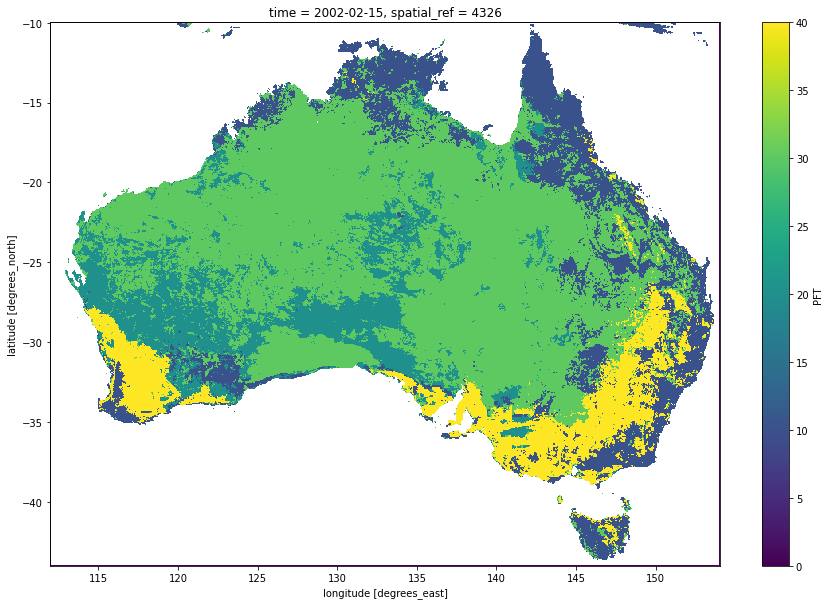

In [7]:
lc.PFT.plot.imshow(size=10)

## MODIS EVI to 5km grid

In [ ]:
import os
import xarray as xr
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/data/EVI_annual/'
ds = xr.open_mfdataset([base+i for i in os.listdir(base)], chunks=dict(time=1))

In [ ]:
#open chrips (reproject to this)
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

ds = xr_reproject(ds, geobox=chirps.geobox, resampling='nearest')
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')

In [ ]:
ds = ds.compute()

In [ ]:
ds.EVI.isel(time=200).plot.imshow(size=8, vmin=0);

In [ ]:
ds = ds.astype('float32')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/EVI_5km_monthly_2002_2021.nc');

## Aridity Index

In [14]:
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
import rioxarray
import numpy as np
import xarray as xr

In [15]:
ai = rioxarray.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/ai_v3_yr.tif').squeeze().drop('band').isel(x=range(35000,40500), y=range(11750,16250))

In [16]:
ai = assign_crs(ai, crs='epsg:4326')

In [17]:
ai = ai /10000

In [19]:
#open chrips (reproject to this)
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

ai = xr_reproject(ai, chirps.geobox, resampling='average')
ai['latitude'] = ai.latitude.astype('float32')
ai['longitude'] = ai.longitude.astype('float32')

# make into a time-series
ai = ai.expand_dims(time=chirps.sel(time=slice('2002','2021')).time)
ai = ai.rename('AI')

In [22]:
ai.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AridityIndex_5km_2002_2021.nc')

## L3 Flux tower data

* https://www.ozflux.org.au/monitoringsites/ciamaizewheat/index.html
* https://data.ozflux.org.au/portal/pub/listPubCollections.jspx?pageNo=1&sizePerPage=100

## Fill no-data values in MODIS variables with climatology

In [ ]:
import os
import xarray as xr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [ ]:
cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=24)

In [ ]:
client

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/LAI-annual/'
var='Lai'

In [ ]:
ds = xr.open_mfdataset([base+i for i in os.listdir(base)], chunks=dict(time=1)).astype('float32').persist()

ds[var].isel(time=104).plot.imshow(vmin=0)

In [ ]:
#compute climatology
clim = ds[var].chunk(dict(latitude=750, longitude=750))
clim = ds.groupby("time.month").mean("time").compute()

In [ ]:
clim

In [ ]:
clim.Lai.plot.imshow(col='month')

In [ ]:
# fill nans with climatology and plot cloudiest period
ds = ds.groupby("time.month").fillna(clim)

ds[var].isel(time=104).plot.imshow(vmin=0)

In [ ]:
ds = ds.fillna(0)
ds[var].isel(time=104).plot.imshow()

In [ ]:
## reproject to 5km resolution
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc') # open chrips (reproject to this)

ds_rp = xr_reproject(ds, chirps.geobox, resampling='average').compute()
ds_rp['latitude'] = ds_rp.latitude.astype('float32')
ds_rp['longitude'] = ds_rp.longitude.astype('float32')

ds_rp[var].isel(time=110).plot.imshow(vmin=0)

In [ ]:
ds_rp = ds_rp.rename({'Lai':'LAI'})

In [ ]:
ds_rp.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/LAI_5km_monthly_2002_2021.nc')

## Cumulative rainfall

In [ ]:
import xarray as xr

In [ ]:
rain = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

In [ ]:
rain

In [ ]:
rain_cml_3 = rain.rolling(time=3, min_periods=3).sum()
rain_cml_3 = rain_cml_3.rename({'precip':'precip_cml_3'})

In [ ]:
rain_cml_6 = rain.rolling(time=6, min_periods=6).sum()
rain_cml_6 = rain_cml_6.rename({'precip':'precip_cml_6'})

In [ ]:
rain_cml_3.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_cml3_1991_2021.nc')

In [ ]:
rain_cml_6.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_cml6_1991_2021.nc')